In [0]:
## Imports
from google.colab import drive
drive.mount('/content/drive')
import itertools
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
device = torch.device('cuda') 
import gc
import copy
import json
import multiprocessing as mp
from typing import Any, Dict, List, Optional, Set, Union
import h5py
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import os
from torch.nn.functional import normalize
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset
import pickle
from torch.nn import functional as F

In [0]:
config = {"dataset":{"image_features_train_h5": '/content/drive/Shared drives/Visdial/Visdial_data/features_vgg16_fc7_train.h5',
  "image_features_val_h5": '/content/drive/Shared drives/Visdial/Visdial_data/features_vgg16_fc7_val.h5',
  "image_features_test_h5": '/content/drive/Shared drives/Visdial/Visdial_data/features_vgg16_fc7_val.h5',
  "word_counts_json": '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_word_counts_train.json',
  "img_norm": 1,
  "concat_history": True,
  "max_sequence_length": 20,
  "vocab_min_count": 5},

# Model related arguments
"model":
 { "encoder": 'lf',
  "decoder": 'disc',
  "img_feature_size": 4096,
  "word_embedding_size": 300,
  "lstm_hidden_size": 512,
  "lstm_num_layers": 2,
  "dropout": 0.5},

# Optimization related arguments
"solver":
  {"batch_size": 4 ,# 32 x num_gpus is a good rule of thumb,
  "num_epochs": 10,
  "initial_lr": 0.001,
  "training_splits": "train" , # "trainval"
  "lr_gamma": 0.1,
  "warmup_factor": 0.2,
  "warmup_epochs": 1
  }}

In [0]:
class DialogsReader(object):
    """
    A simple reader for VisDial v1.0 dialog data. 
    Parameters
    dialogs_jsonpath : str, Path to json file containing VisDial v1.0 train, val or test data.
    num_examples: int, optional (default = None)
        Process first "num_examples" from the split. Useful to speed up while
        debugging.
    """

    def __init__(
        self,
        dialogs_jsonpath: str,
        num_examples: Optional[int] = None,
        num_workers: int = 1,
    ):
        with open(dialogs_jsonpath, "r") as visdial_file:
            visdial_data = json.load(visdial_file)
            self._split = visdial_data["split"]

            # Maintain questions and answers as a dict instead of list because
            # they are referenced by index in dialogs. We drop elements from
            # these in "overfit" mode to save time (tokenization is slow).
            self.questions = {
                i: question for i, question in
                enumerate(visdial_data["data"]["questions"])
            }
            self.answers = {
                i: answer for i, answer in
                enumerate(visdial_data["data"]["answers"])
            }

            # Add empty question, answer - useful for padding dialog rounds
            # for test split.
            self.questions[-1] = ""
            self.answers[-1] = ""

            # "image_id" serves as key for all three dicts here.
            self.captions: Dict[int, Any] = {}
            self.dialogs: Dict[int, Any] = {}
            self.num_rounds: Dict[int, Any] = {}

            all_dialogs = visdial_data["data"]["dialogs"]

            # Retain only first "num_examples" dialogs if specified.
            if num_examples is not None:
                all_dialogs = all_dialogs[:num_examples]

            for _dialog in all_dialogs:

                self.captions[_dialog["image_id"]] = _dialog["caption"]

                # Record original length of dialog, before padding.
                # 10 for train and val splits, 10 or less for test split.
                self.num_rounds[_dialog["image_id"]] = len(_dialog["dialog"])

                # Pad dialog at the end with empty question and answer pairs
                # (for test split).
                while len(_dialog["dialog"]) < 10:
                    _dialog["dialog"].append({"question": -1, "answer": -1})

                # Add empty answer (and answer options) if not provided
                # (for test split). We use "-1" as a key for empty questions
                # and answers.
                for i in range(len(_dialog["dialog"])):
                    if "answer" not in _dialog["dialog"][i]:
                        _dialog["dialog"][i]["answer"] = -1
                    if "answer_options" not in _dialog["dialog"][i]:
                        _dialog["dialog"][i]["answer_options"] = [-1] * 100

                self.dialogs[_dialog["image_id"]] = _dialog["dialog"]

            # If ``num_examples`` is specified, collect questions and answers
            # included in those examples, and drop the rest to save time 
            if num_examples is not None:
                questions_included: Set[int] = set()
                answers_included: Set[int] = set()

                for _dialog in self.dialogs.values():
                    for _dialog_round in _dialog:
                        questions_included.add(_dialog_round["question"])
                        answers_included.add(_dialog_round["answer"])
                        for _answer_option in _dialog_round["answer_options"]:
                            answers_included.add(_answer_option)

                self.questions = {
                    i: self.questions[i] for i in questions_included
                }
                self.answers = {
                    i: self.answers[i] for i in answers_included
                }

            self._multiprocess_tokenize(num_workers)

    def _multiprocess_tokenize(self, num_workers: int):
        """
        Tokenize captions, questions and answers in parallel processes. 
        Since questions, answers and captions are dicts - and multiprocessing
        map operate on lists, we convert these to lists first and
        then back to dicts.
        Parameters
        ----------
        num_workers: int
            Number of workers (processes) to run in parallel.
        """

        # While displaying progress bar through tqdm, specify total number of
        # sequences to tokenize, because tqdm won't know in case of pool.imap
        with mp.Pool(num_workers) as pool:
            print(f"[{self._split}] Tokenizing questions...")
            _question_tuples = self.questions.items()
            _question_indices = [t[0] for t in _question_tuples]
            _questions = list(
                tqdm(
                    pool.imap(word_tokenize, [t[1] for t in _question_tuples]),
                    total=len(self.questions)
                )
            )
            self.questions = {
                i: question + ["?"] for i, question in
                zip(_question_indices, _questions)
            }
            # Delete variables to free memory.
            del _question_tuples, _question_indices, _questions

            print(f"[{self._split}] Tokenizing answers...")
            _answer_tuples = self.answers.items()
            _answer_indices = [t[0] for t in _answer_tuples]
            _answers = list(
                tqdm(
                    pool.imap(word_tokenize, [t[1] for t in _answer_tuples]),
                    total=len(self.answers)
                )
            )
            self.answers = {
                i: answer + ["?"] for i, answer in
                zip(_answer_indices, _answers)
            }
            # Delete variables to free memory.
            del _answer_tuples, _answer_indices, _answers

            print(f"[{self._split}] Tokenizing captions...")
            # Convert dict to separate lists of image_ids and captions.
            _caption_tuples = self.captions.items()
            _image_ids = [t[0] for t in _caption_tuples]
            _captions = list(
                tqdm(
                    pool.imap(word_tokenize, [t[1] for t in _caption_tuples]),
                    total=(len(_caption_tuples))
                )
            )
            # Convert tokenized captions back to a dict.
            self.captions = {i: c for i, c in zip(_image_ids, _captions)}

    def __len__(self):
        return len(self.dialogs)

    def __getitem__(self, image_id: int) -> Dict[str, Union[int, str, List]]:
        caption_for_image = self.captions[image_id]
        dialog = copy.copy(self.dialogs[image_id])
        num_rounds = self.num_rounds[image_id]

        # Replace question and answer indices with actual word tokens.
        for i in range(len(dialog)):
            dialog[i]["question"] = self.questions[
                dialog[i]["question"]
            ]
            dialog[i]["answer"] = self.answers[
                dialog[i]["answer"]
            ]
            for j, answer_option in enumerate(
                dialog[i]["answer_options"]
            ):
                dialog[i]["answer_options"][j] = self.answers[
                    answer_option
                ]

        return {
            "image_id": image_id,
            "caption": caption_for_image,
            "dialog": dialog,
            "num_rounds": num_rounds,
        }

    def keys(self) -> List[int]:
        return list(self.dialogs.keys())

    @property
    def split(self):
        return self._split


class DenseAnnotationsReader(object):
    """
    A reader for dense annotations for val split.
    Parameters
    ----------
    dense_annotations_jsonpath : str, Path to a json file containing VisDial v1.0
    """

    def __init__(self, dense_annotations_jsonpath: str):
        with open(dense_annotations_jsonpath, "r") as visdial_file:
            self._visdial_data = json.load(visdial_file)
            self._image_ids = [
                entry["image_id"] for entry in self._visdial_data
            ]

    def __len__(self):
        return len(self._image_ids)

    def __getitem__(self, image_id: int) -> Dict[str, Union[int, List]]:
        index = self._image_ids.index(image_id)
        # keys: {"image_id", "round_id", "gt_relevance"}
        return self._visdial_data[index]

    @property
    def split(self):
        # always
        return "val"


class ImageFeaturesHdfReader(object):
    """
    A reader for HDF files containing pre-extracted image features. A typical
    HDF file is expected to have a column named "image_id", and another column
    named "features".
    Example of an HDF file:
    ```
    visdial_train_vgg_bottomup_features.h5
       |--- "image_id" [shape: (num_images, )]
       |--- "features" [shape: (num_images, num_proposals, feature_size)]
       +--- .attrs ("split", "train")
    ```
    Parameters
    ----------
    features_hdfpath : str
        Path to an HDF file containing VisDial v1.0 train, val or test split
        image features.
    in_memory : bool
        Whether to load the whole HDF file in memory.
    """

    def __init__(self, features_hdfpath: str, in_memory: bool = False):
        self.features_hdfpath = features_hdfpath
        self._in_memory = in_memory

        with h5py.File(self.features_hdfpath, "r") as features_hdf:
            self._split = features_hdf.attrs["split"]
            self._image_id_list = list(features_hdf["image_id"])
            # "features" is List[np.ndarray] if the dataset is loaded in-memory
            # If not loaded in memory, then list of None.
            self.features = [None] * len(self._image_id_list)

    def __len__(self):
        return len(self._image_id_list)

    def __getitem__(self, image_id: int):
        index = self._image_id_list.index(image_id)
        if self._in_memory:
            # Load features during first epoch, all not loaded together as it
            # has a slow start.
            if self.features[index] is not None:
                image_id_features = self.features[index]
            else:
                with h5py.File(self.features_hdfpath, "r") as features_hdf:
                    image_id_features = features_hdf["features"][index]
                    self.features[index] = image_id_features
        else:
            # Read chunk from file everytime if not loaded in memory.
            with h5py.File(self.features_hdfpath, "r") as features_hdf:
                image_id_features = features_hdf["features"][index]

        return image_id_features

    def keys(self) -> List[int]:
        return self._image_id_list

    @property
    def split(self):
        return self._split

In [0]:
"""
A Vocabulary maintains a mapping between words and corresponding unique
integers, holds special integers (tokens) for indicating start and end of
sequence, and offers functionality to map out-of-vocabulary words to the
corresponding token.
"""
import os


class Vocabulary(object):
    """
    A simple Vocabulary class which maintains a mapping between words and
    integer tokens. Can be initialized either by word counts from the VisDial
    v1.0 train dataset, or a pre-saved vocabulary mapping.
    Parameters
    ----------
    word_counts_path: str
        Path to a json file containing counts of each word across captions,
        questions and answers of the VisDial v1.0 train dataset.
    min_count : int, optional (default=0)
        When initializing the vocabulary from word counts, can specify a
        minimum count, and every token with a count less than this will be
        excluded from vocabulary.
    """

    PAD_TOKEN = "<PAD>"
    SOS_TOKEN = "<S>"
    EOS_TOKEN = "</S>"
    UNK_TOKEN = "<UNK>"

    PAD_INDEX = 0
    SOS_INDEX = 1
    EOS_INDEX = 2
    UNK_INDEX = 3

    def __init__(self, word_counts_path: str, min_count: int = 5):
        if not os.path.exists(word_counts_path):
            raise FileNotFoundError(
                f"Word counts do not exist at {word_counts_path}"
            )

        with open(word_counts_path, "r") as word_counts_file:
            word_counts = json.load(word_counts_file)

            # form a list of (word, count) tuples and apply min_count threshold
            word_counts = [
                (word, count)
                for word, count in word_counts.items()
                if count >= min_count
            ]
            # sort in descending order of word counts
            word_counts = sorted(word_counts, key=lambda wc: -wc[1])
            words = [w[0] for w in word_counts]

        self.word2index = {}
        self.word2index[self.PAD_TOKEN] = self.PAD_INDEX
        self.word2index[self.SOS_TOKEN] = self.SOS_INDEX
        self.word2index[self.EOS_TOKEN] = self.EOS_INDEX
        self.word2index[self.UNK_TOKEN] = self.UNK_INDEX
        for index, word in enumerate(words):
            self.word2index[word] = index + 4

        self.index2word = {
            index: word for word, index in self.word2index.items()
        }

    @classmethod
    def from_saved(cls, saved_vocabulary_path: str) -> "Vocabulary":
        """Build the vocabulary from a json file saved by ``save`` method.
        Parameters
        ----------
        saved_vocabulary_path : str
            Path to a json file containing word to integer mappings
            (saved vocabulary).
        """
        with open(saved_vocabulary_path, "r") as saved_vocabulary_file:
            cls.word2index = json.load(saved_vocabulary_file)
        cls.index2word = {
            index: word for word, index in cls.word2index.items()
        }

    def to_indices(self, words: List[str]) -> List[int]:
        return [self.word2index.get(word, self.UNK_INDEX) for word in words]

    def to_words(self, indices: List[int]) -> List[str]:
        return [
            self.index2word.get(index, self.UNK_TOKEN) for index in indices
        ]

    def save(self, save_vocabulary_path: str) -> None:
        with open(save_vocabulary_path, "w") as save_vocabulary_file:
            json.dump(self.word2index, save_vocabulary_file)

    def __len__(self):
        return len(self.index2word)

In [0]:
class VisDialDataset(Dataset):
    """
    A full representation of VisDial v1.0 (train/val/test) dataset. According
    to the appropriate split, it returns dictionary of question, image,
    history, ground truth answer, answer options, dense annotations etc.
    """

    def __init__(
        self,
        config,
        dialogs_jsonpath: str,
        dense_annotations_jsonpath: Optional[str] = None,
        overfit: bool = False,
        in_memory: bool = False,
        num_workers: int = 1,
        return_options: bool = True,
        add_boundary_toks: bool = False,
    ):
        super().__init__()
        self.config = config
        self.return_options = return_options
        self.add_boundary_toks = add_boundary_toks
        self.dialogs_reader = DialogsReader(
            dialogs_jsonpath,
            num_examples=(5 if overfit else None),
            num_workers=num_workers
        )

        if "val" in self.split and dense_annotations_jsonpath is not None:
            self.annotations_reader = DenseAnnotationsReader(
                dense_annotations_jsonpath
            )
        else:
            self.annotations_reader = None

        self.vocabulary = Vocabulary(
            config["word_counts_json"], min_count=config["vocab_min_count"]
        )

        # Initialize image features reader according to split.
        image_features_hdfpath = config["image_features_train_h5"]
        if "val" in self.dialogs_reader.split:
            print("in val")
            image_features_hdfpath = config["image_features_val_h5"]
        elif "test" in self.dialogs_reader.split:
            image_features_hdfpath = config["image_features_test_h5"]

        self.hdf_reader = ImageFeaturesHdfReader(
            image_features_hdfpath, in_memory
        )

        # Keep a list of image_ids as primary keys to access data.
        self.image_ids = list(self.dialogs_reader.dialogs.keys())
        if overfit:
            self.image_ids = self.image_ids[:5]

    @property
    def split(self):
        return self.dialogs_reader.split

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        # Get image_id, which serves as a primary key for current instance.
        image_id = self.image_ids[index]

        # Get image features for this image_id using hdf reader.
        image_features = self.hdf_reader[image_id]
        image_features = torch.tensor(image_features)
        # Normalize image features at zero-th dimension (since there's no batch
        # dimension).
        if self.config["img_norm"]:
            image_features = normalize(image_features, dim=0, p=2)

        # Retrieve instance for this image_id using json reader.
        visdial_instance = self.dialogs_reader[image_id]
        caption = visdial_instance["caption"]
        dialog = visdial_instance["dialog"]

        # Convert word tokens of caption, question, answer and answer options
        # to integers.
        caption = self.vocabulary.to_indices(caption)
        for i in range(len(dialog)):
            dialog[i]["question"] = self.vocabulary.to_indices(
                dialog[i]["question"]
            )
            if self.add_boundary_toks:
                dialog[i]["answer"] = self.vocabulary.to_indices(
                    [self.vocabulary.SOS_TOKEN]
                    + dialog[i]["answer"]
                    + [self.vocabulary.EOS_TOKEN]
                )
            else:
                dialog[i]["answer"] = self.vocabulary.to_indices(
                    dialog[i]["answer"]
                )

            if self.return_options:
                for j in range(len(dialog[i]["answer_options"])):
                    if self.add_boundary_toks:
                        dialog[i]["answer_options"][
                            j
                        ] = self.vocabulary.to_indices(
                            [self.vocabulary.SOS_TOKEN]
                            + dialog[i]["answer_options"][j]
                            + [self.vocabulary.EOS_TOKEN]
                        )
                    else:
                        dialog[i]["answer_options"][
                            j
                        ] = self.vocabulary.to_indices(
                            dialog[i]["answer_options"][j]
                        )

        questions, question_lengths = self._pad_sequences(
            [dialog_round["question"] for dialog_round in dialog]
        )
        history, history_lengths = self._get_history(
            caption,
            [dialog_round["question"] for dialog_round in dialog],
            [dialog_round["answer"] for dialog_round in dialog],
        )
        answers_in, answer_lengths = self._pad_sequences(
            [dialog_round["answer"][:-1] for dialog_round in dialog]
        )
        answers_out, _ = self._pad_sequences(
            [dialog_round["answer"][1:] for dialog_round in dialog]
        )

        # Collect everything as tensors for ``collate_fn`` of dataloader to
        # work seamlessly questions, history, etc. are converted to
        # LongTensors, for nn.Embedding input.
        item = {}
        item["img_ids"] = torch.tensor(image_id).long()
        item["img_feat"] = image_features
        item["ques"] = questions.long()
        item["hist"] = history.long()
        item["ans_in"] = answers_in.long()
        item["ans_out"] = answers_out.long()
        item["ques_len"] = torch.tensor(question_lengths).long()
        item["hist_len"] = torch.tensor(history_lengths).long()
        item["ans_len"] = torch.tensor(answer_lengths).long()
        item["num_rounds"] = torch.tensor(
            visdial_instance["num_rounds"]
        ).long()

        if self.return_options:
            if self.add_boundary_toks:
                answer_options_in, answer_options_out = [], []
                answer_option_lengths = []
                for dialog_round in dialog:
                    options, option_lengths = self._pad_sequences(
                        [
                            option[:-1]
                            for option in dialog_round["answer_options"]
                        ]
                    )
                    answer_options_in.append(options)

                    options, _ = self._pad_sequences(
                        [
                            option[1:]
                            for option in dialog_round["answer_options"]
                        ]
                    )
                    answer_options_out.append(options)

                    answer_option_lengths.append(option_lengths)
                answer_options_in = torch.stack(answer_options_in, 0)
                answer_options_out = torch.stack(answer_options_out, 0)

                item["opt_in"] = answer_options_in.long()
                item["opt_out"] = answer_options_out.long()
                item["opt_len"] = torch.tensor(answer_option_lengths).long()
            else:
                answer_options = []
                answer_option_lengths = []
                for dialog_round in dialog:
                    options, option_lengths = self._pad_sequences(
                        dialog_round["answer_options"]
                    )
                    answer_options.append(options)
                    answer_option_lengths.append(option_lengths)
                answer_options = torch.stack(answer_options, 0)

                item["opt"] = answer_options.long()
                item["opt_len"] = torch.tensor(answer_option_lengths).long()

            if "test" not in self.split:
                answer_indices = [
                    dialog_round["gt_index"] for dialog_round in dialog
                ]
                item["ans_ind"] = torch.tensor(answer_indices).long()

        # Gather dense annotations.
        if "val" in self.split:
            dense_annotations = self.annotations_reader[image_id]
            item["gt_relevance"] = torch.tensor(
                dense_annotations["gt_relevance"]
            ).float()
            item["round_id"] = torch.tensor(
                dense_annotations["round_id"]
            ).long()

        return item

    def _pad_sequences(self, sequences: List[List[int]]):
        """Given tokenized sequences (either questions, answers or answer
        options, tokenized in ``__getitem__``), padding them to maximum
        specified sequence length. Return as a tensor of size
        ``(*, max_sequence_length)``.
        This method is only called in ``__getitem__``, chunked out separately
        for readability.
        Parameters
        ----------
        sequences : List of tokenized sequences, each sequence is typically a
            List[int].
        Returns
        -------
            Tensor of sequences padded to max length, and length of sequences
            before padding.
        """

        for i in range(len(sequences)):
            sequences[i] = sequences[i][
                : self.config["max_sequence_length"] - 1
            ]
        sequence_lengths = [len(sequence) for sequence in sequences]

        # Pad all sequences to max_sequence_length.
        maxpadded_sequences = torch.full(
            (len(sequences), self.config["max_sequence_length"]),
            fill_value=self.vocabulary.PAD_INDEX,
        )
        padded_sequences = pad_sequence(
            [torch.tensor(sequence) for sequence in sequences],
            batch_first=True,
            padding_value=self.vocabulary.PAD_INDEX,
        )
        maxpadded_sequences[:, : padded_sequences.size(1)] = padded_sequences
        return maxpadded_sequences, sequence_lengths

    def _get_history(
        self,
        caption: List[int],
        questions: List[List[int]],
        answers: List[List[int]],
    ):
        # Allow double length of caption, equivalent to a concatenated QA pair.
        caption = caption[: self.config["max_sequence_length"] * 2 - 1]

        for i in range(len(questions)):
            questions[i] = questions[i][
                : self.config["max_sequence_length"] - 1
            ]

        for i in range(len(answers)):
            answers[i] = answers[i][: self.config["max_sequence_length"] - 1]

        # History for first round is caption, else concatenated QA pair of
        # previous round.
        history = []
        history.append(caption)
        for question, answer in zip(questions, answers):
            history.append(question + answer + [self.vocabulary.EOS_INDEX])
        # Drop last entry from history (there's no eleventh question).
        history = history[:-1]
        max_history_length = self.config["max_sequence_length"] * 2

        if self.config.get("concat_history", False):
            # Concatenated_history has similar structure as history, except it
            # contains concatenated QA pairs from previous rounds.
            concatenated_history = []
            concatenated_history.append(caption)
            for i in range(1, len(history)):
                concatenated_history.append([])
                for j in range(i + 1):
                    concatenated_history[i].extend(history[j])

            max_history_length = (
                self.config["max_sequence_length"] * 2 * len(history)
            )
            history = concatenated_history

        history_lengths = [len(round_history) for round_history in history]
        maxpadded_history = torch.full(
            (len(history), max_history_length),
            fill_value=self.vocabulary.PAD_INDEX,
        )
        padded_history = pad_sequence(
            [torch.tensor(round_history) for round_history in history],
            batch_first=True,
            padding_value=self.vocabulary.PAD_INDEX,
        )
        maxpadded_history[:, : padded_history.size(1)] = padded_history
        return maxpadded_history, history_lengths

In [0]:
# train_dataset = VisDialDataset(
#     config["dataset"],
#     '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_train.json',
#     overfit=False,
#     in_memory=False,
#     num_workers=1,
#     return_options=True,
#     add_boundary_toks=False
# )

# val_dataset = VisDialDataset(
#     config["dataset"],
#     '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_val.json',
#     '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_val_dense_annotations.json',
#     overfit=False,
#     in_memory=False,
#     num_workers=1,
#     return_options=True,
#     add_boundary_toks=False
# )

In [0]:
dataset_train = pickle.load(open("/content/drive/Shared drives/Visdial/Visdial_data/train_data_set.pickle","rb"))
dataset_val = pickle.load(open("/content/drive/Shared drives/Visdial/Visdial_data/val_data_set.pickle","rb"))

In [0]:
class DynamicRNN(nn.Module):
    def __init__(self, rnn_model):
        super().__init__()
        self.rnn_model = rnn_model

    def forward(self, seq_input, seq_lens, initial_state=None):
        """A wrapper over pytorch's rnn to handle sequences of variable length.
        Arguments
        ---------
        seq_input : Input sequence tensor (padded) for RNN model.
            Shape: (batch_size, max_sequence_length, embed_size)
        seq_lens :  Length of sequences (b, )
        initial_state :  Initial (hidden, cell) states of RNN model.
        Returns
        -------
            Single tensor of shape (batch_size, rnn_hidden_size) corresponding
            to the outputs of the RNN model at the last time step of each input
            sequence.
        """
        max_sequence_length = seq_input.size(1)
        sorted_len, fwd_order, bwd_order = self._get_sorted_order(seq_lens)
        sorted_seq_input = seq_input.index_select(0, fwd_order)
        packed_seq_input = pack_padded_sequence(
            sorted_seq_input, lengths=sorted_len, batch_first=True
        )

        if initial_state is not None:
            hx = initial_state
            assert hx[0].size(0) == self.rnn_model.num_layers
        else:
            hx = None

        self.rnn_model.flatten_parameters()
        outputs, (h_n, c_n) = self.rnn_model(packed_seq_input, hx)

        # pick hidden and cell states of last layer
        h_n = h_n[-1].index_select(dim=0, index=bwd_order)
        c_n = c_n[-1].index_select(dim=0, index=bwd_order)

        outputs = pad_packed_sequence(
            outputs, batch_first=True, total_length=max_sequence_length
        )
        return outputs, (h_n, c_n)

    @staticmethod
    def _get_sorted_order(lens):
        sorted_len, fwd_order = torch.sort(
            lens.contiguous().view(-1), 0, descending=True
        )
        _, bwd_order = torch.sort(fwd_order)
        sorted_len = list(sorted_len)
        return sorted_len, fwd_order, bwd_order

##### **Embedding Layer prequisites:**

In [0]:
## BERT embedding layer weights
bert_weights = pickle.load(open("/content/drive/Shared drives/Visdial/Visdial_data/bert_weights.pickle","rb"))
## Glove Embeddings
######## PUT HERE ############333

In [0]:
class LateFusionEncoder(nn.Module):
    def __init__(self, config, vocabulary,embedd_type='Word2Vec'):
        super().__init__()
        self.config = config
        if embedd_type == 'bert':
          self.word_embed = nn.Embedding.from_pretrained(bert_weights)
          self.hist_rnn = nn.LSTM(
              768,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
          
          self.ques_rnn = nn.LSTM(
              768,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
        else:
          self.word_embed = nn.Embedding(
              len(vocabulary),
              config["word_embedding_size"],
              padding_idx=vocabulary.PAD_INDEX,
          )          
          self.hist_rnn = nn.LSTM(
              300,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
          
          self.ques_rnn = nn.LSTM(
              300,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
        self.dropout = nn.Dropout(p=config["dropout"])
       
        # questions and history are right padded sequences of variable length
        # uses the DynamicRNN 
        self.hist_rnn = DynamicRNN(self.hist_rnn)
        self.ques_rnn = DynamicRNN(self.ques_rnn)

        # project image features to lstm_hidden_size for computing attention
        self.image_features_projection = nn.Linear(
            config["img_feature_size"], config["lstm_hidden_size"]
        )

        # fc layer for image * question to attention weights
        self.attention_proj = nn.Linear(config["lstm_hidden_size"], 1)

        # fusion layer (attended_image_features + question + history)
        fusion_size = (
            config["img_feature_size"] + config["lstm_hidden_size"] * 2
        )
        self.fusion = nn.Linear(fusion_size, config["lstm_hidden_size"])

        nn.init.kaiming_uniform_(self.image_features_projection.weight)
        nn.init.constant_(self.image_features_projection.bias, 0)
        nn.init.kaiming_uniform_(self.fusion.weight)
        nn.init.constant_(self.fusion.bias, 0)

    def forward(self, batch):
        img = batch["img_feat"]
        ques = batch["ques"]
        hist = batch["hist"]
        batch_size, num_rounds, max_sequence_length = ques.size()
        # embedded questions
        ques = ques.view(batch_size * num_rounds, max_sequence_length)
        ques_embed = self.word_embed(ques)
        _, (ques_embed, _) = self.ques_rnn(ques_embed, batch["ques_len"])
        # project down image features and ready for attention
        projected_image_features = self.image_features_projection(img)
        # repeat image feature vectors to be provided for every round
        projected_image_features = (
            projected_image_features.view(
                batch_size, 1, -1, self.config["lstm_hidden_size"]
            )
            .repeat(1, num_rounds, 1, 1)
            .view(batch_size * num_rounds, -1, self.config["lstm_hidden_size"])
        )
        # computing attention weights
        projected_ques_features = ques_embed.unsqueeze(1).repeat(
            1, img.shape[1], 1
        )
        projected_ques_image = (projected_ques_features * projected_image_features)

        projected_ques_image = self.dropout(projected_ques_image)
        image_attention_weights = self.attention_proj(projected_ques_image).squeeze()
        image_attention_weights = F.softmax(image_attention_weights, dim=-1)

        img = (
            img.view(batch_size, 1, -1, self.config["img_feature_size"])
            .repeat(1, num_rounds, 1, 1)
            .view(batch_size * num_rounds, -1, self.config["img_feature_size"])
        )

        # multiply image features with their attention weights
        image_attention_weights = image_attention_weights.unsqueeze(-1).repeat(
            1, 1, self.config["img_feature_size"]
        )
        attended_image_features = (image_attention_weights * img).sum(1)
        img = attended_image_features

        # embedded history
        hist = hist.view(batch_size * num_rounds, max_sequence_length * 20)
        hist_embed = self.word_embed(hist)

        _, (hist_embed, _) = self.hist_rnn(hist_embed, batch["hist_len"])

        fused_vector = torch.cat((img, ques_embed, hist_embed), 1)
        fused_vector = self.dropout(fused_vector)

        fused_embedding = torch.tanh(self.fusion(fused_vector))
        fused_embedding = fused_embedding.view(batch_size, num_rounds, -1)
        return fused_embedding

In [0]:
def Encoder(model_config, *args):
    name_enc_map = {"lf": LateFusionEncoder}
    return name_enc_map[model_config["encoder"]](model_config, *args)

In [0]:
def Decoder(model_config, *args):
    name_dec_map = {"disc": DiscriminativeDecoder}
    return name_dec_map[model_config["decoder"]](model_config, *args)

In [0]:
class DiscriminativeDecoder(nn.Module):
    def __init__(self, config, vocabulary,embedd_type = 'Word2Vec'):
        super().__init__()
        self.config = config
        self.embed_type = embed_type
        if embedd_type == 'bert':
          self.word_embed = nn.Embedding.from_pretrained(bert_weights)
        
          self.option_rnn = nn.LSTM(
              768,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
        else:
          self.word_embed = nn.Embedding(
              len(vocabulary),
              padding_idx=vocabulary.PAD_INDEX,
          )
          self.option_rnn = nn.LSTM(
              300,
              config["lstm_hidden_size"],
              config["lstm_num_layers"],
              batch_first=True,
              dropout=config["dropout"],
          )
        self.option_rnn = DynamicRNN(self.option_rnn)

    def forward(self, encoder_output, batch):
        """Given `encoder_output` + candidate option sequences, predict a score
        for each option sequence.
        Parameters
        ----------
        encoder_output: torch.Tensor
            Output from the encoder through its forward pass.
            (batch_size, num_rounds, lstm_hidden_size)
        """
        options = batch["opt"]
        batch_size, num_rounds, num_options, max_sequence_length = (
            options.size()
        )
        options = options.view(
            batch_size * num_rounds * num_options, max_sequence_length
        )

        options_length = batch["opt_len"]
        options_length = options_length.view(
            batch_size * num_rounds * num_options
        )
        # Pick options with non-zero length (relevant for test split).
        nonzero_options_length_indices = options_length.nonzero().squeeze()
        nonzero_options_length = options_length[nonzero_options_length_indices]
        nonzero_options = options[nonzero_options_length_indices]
        nonzero_options_embed = self.word_embed(nonzero_options)

        _, (nonzero_options_embed, _) = self.option_rnn(
            nonzero_options_embed, nonzero_options_length
        )
        options_embed = torch.zeros(
            batch_size * num_rounds * num_options,
            nonzero_options_embed.size(-1),
            device=nonzero_options_embed.device,
        )
        options_embed[nonzero_options_length_indices] = nonzero_options_embed
        # Repeat encoder output for every option.
        encoder_output = encoder_output.unsqueeze(2).repeat(
            1, 1, num_options, 1
        )
        encoder_output = encoder_output.view(
            batch_size * num_rounds * num_options,
            self.config["lstm_hidden_size"],
        )
        scores = torch.sum(options_embed * encoder_output, 1)
        scores = scores.view(batch_size, num_rounds, num_options)
        return scores

In [0]:
class EncoderDecoderModel(nn.Module):
    """Convenience wrapper module, wrapping Encoder and Decoder modules.
    Parameters
    ----------
    encoder: nn.Module
    decoder: nn.Module
    """

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, batch):
        encoder_output = self.encoder(batch)
        decoder_output = self.decoder(encoder_output, batch)
        return decoder_output


In [0]:
## Pass vocabulary to construct Embedding layer.
encoder = Encoder(config["model"], dataset_train.vocabulary)
decoder = Decoder(config["model"], dataset_train.vocabulary)
print("Encoder: {}".format(config["model"]["encoder"]))
print("Decoder: {}".format(config["model"]["decoder"]))

Encoder: lf
Decoder: disc


In [0]:
# import numpy as np
# data_batched_train = torch.utils.data.Subset(dataset_train, np.arange(10000))
# train_dataloader = DataLoader(
#     data_batched_train,
#     batch_size=config["solver"]["batch_size"],
#     num_workers=2,
#     shuffle=True)
# val_dataset = VisDialDataset(
#     config["dataset"],
#     '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_val.json',
#     '/content/drive/Shared drives/Visdial/Visdial_data/visdial_1.0_val_dense_annotations.json',
#     overfit=False,
#     in_memory=False,
#     num_workers=1,
#     return_options=True,
#     add_boundary_toks=False
# )
# val_dataloader = DataLoader(
#     dataset_val,
#     batch_size=config["solver"]["batch_size"]
#     if config["model"]["decoder"] == "disc"
#     else 5,
#     num_workers=1,
# )

In [0]:
"""
A Metric observes output of certain model, for example, in form of logits or
scores, and accumulates a particular metric with reference to some provided
targets. In context of VisDial, we use Recall (@ 1, 5, 10), Mean Rank, Mean
Reciprocal Rank (MRR) and Normalized Discounted Cumulative Gain (NDCG).
Each ``Metric`` must atleast implement three methods:
    - ``observe``, update accumulated metric with currently observed outputs
      and targets.
    - ``retrieve`` to return the accumulated metric., an optionally reset
      internally accumulated metric (this is commonly done between two epochs
      after validation).
    - ``reset`` to explicitly reset the internally accumulated metric.
Caveat, if you wish to implement your own class of Metric, make sure you call
``detach`` on output tensors (like logits), else it will cause memory leaks.
"""


def scores_to_ranks(scores: torch.Tensor):
    """Convert model output scores into ranks."""
    batch_size, num_rounds, num_options = scores.size()
    scores = scores.view(-1, num_options)

    # sort in descending order - largest score gets highest rank
    sorted_ranks, ranked_idx = scores.sort(1, descending=True)

    # i-th position in ranked_idx specifies which score shall take this
    # position but we want i-th position to have rank of score at that
    # position, do this conversion
    ranks = ranked_idx.clone().fill_(0)
    for i in range(ranked_idx.size(0)):
        for j in range(num_options):
            ranks[i][ranked_idx[i][j]] = j
    # convert from 0-99 ranks to 1-100 ranks
    ranks += 1
    ranks = ranks.view(batch_size, num_rounds, num_options)
    return ranks


class SparseGTMetrics(object):
    """
    A class to accumulate all metrics with sparse ground truth annotations.
    These include Recall (@ 1, 5, 10), Mean Rank and Mean Reciprocal Rank.
    """

    def __init__(self):
        self._rank_list = []

    def observe(
        self, predicted_scores: torch.Tensor, target_ranks: torch.Tensor
    ):
        predicted_scores = predicted_scores.detach()

        # shape: (batch_size, num_rounds, num_options)
        predicted_ranks = scores_to_ranks(predicted_scores)
        batch_size, num_rounds, num_options = predicted_ranks.size()

        # collapse batch dimension
        predicted_ranks = predicted_ranks.view(
            batch_size * num_rounds, num_options
        )

        # shape: (batch_size * num_rounds, )
        target_ranks = target_ranks.view(batch_size * num_rounds).long()

        # shape: (batch_size * num_rounds, )
        predicted_gt_ranks = predicted_ranks[
            torch.arange(batch_size * num_rounds), target_ranks
        ]
        self._rank_list.extend(list(predicted_gt_ranks.cpu().numpy()))

    def retrieve(self, reset: bool = True):
        num_examples = len(self._rank_list)
        if num_examples > 0:
            # convert to numpy array for easy calculation.
            __rank_list = torch.tensor(self._rank_list).float()
            metrics = {
                "r@1": torch.mean((__rank_list <= 1).float()).item(),
                "r@5": torch.mean((__rank_list <= 5).float()).item(),
                "r@10": torch.mean((__rank_list <= 10).float()).item(),
                "mean": torch.mean(__rank_list).item(),
                "mrr": torch.mean(__rank_list.reciprocal()).item(),
            }
        else:
            metrics = {}

        if reset:
            self.reset()
        return metrics

    def reset(self):
        self._rank_list = []


class NDCG(object):
    def __init__(self):
        self._ndcg_numerator = 0.0
        self._ndcg_denominator = 0.0

    def observe(
        self, predicted_scores: torch.Tensor, target_relevance: torch.Tensor
    ):
        """
        Observe model output scores and target ground truth relevance and
        accumulate NDCG metric.
        Parameters
        ----------
        predicted_scores: A tensor of shape (batch_size, num_options), because dense
            annotations are available for 1 randomly picked round out of 10.
        target_relevance: A tensor of shape same as predicted scores, indicating ground truth
            relevance of each answer option for a particular round.
        """
        predicted_scores = predicted_scores.detach()

        # shape: (batch_size, 1, num_options)
        predicted_scores = predicted_scores.unsqueeze(1)
        predicted_ranks = scores_to_ranks(predicted_scores)

        # shape: (batch_size, num_options)
        predicted_ranks = predicted_ranks.squeeze()
        batch_size, num_options = predicted_ranks.size()

        k = torch.sum(target_relevance != 0, dim=-1)

        # shape: (batch_size, num_options)
        _, rankings = torch.sort(predicted_ranks, dim=-1)
        # Sort relevance in descending order so highest relevance gets top rnk.
        _, best_rankings = torch.sort(
            target_relevance, dim=-1, descending=True
        )

        # shape: (batch_size, )
        batch_ndcg = []
        for batch_index in range(batch_size):
            num_relevant = k[batch_index]
            dcg = self._dcg(
                rankings[batch_index][:num_relevant],
                target_relevance[batch_index],
            )
            best_dcg = self._dcg(
                best_rankings[batch_index][:num_relevant],
                target_relevance[batch_index],
            )
            batch_ndcg.append(dcg / best_dcg)

        self._ndcg_denominator += batch_size
        self._ndcg_numerator += sum(batch_ndcg)

    def _dcg(self, rankings: torch.Tensor, relevance: torch.Tensor):
        sorted_relevance = relevance[rankings].cpu().float()
        discounts = torch.log2(torch.arange(len(rankings)).float() + 2)
        return torch.sum(sorted_relevance / discounts, dim=-1)

    def retrieve(self, reset: bool = True):
        if self._ndcg_denominator > 0:
            metrics = {
                "ndcg": float(self._ndcg_numerator / self._ndcg_denominator)
            }
        else:
            metrics = {}

        if reset:
            self.reset()
        return metrics

    def reset(self):
        self._ndcg_numerator = 0.0
        self._ndcg_denominator = 0.0

In [0]:
if encoder.embed_type == "glove" :
  encoder.word_embed.weight.data = torch.from_numpy(np.load('/content/drive/Shared drives/Visdial/Visdial_data/glove.npy'))
# Share word embedding between encoder and decoder.
decoder.word_embed = encoder.word_embed
# Wrap encoder and decoder in a model.
model = EncoderDecoderModel(encoder, decoder).to(device)
criterion = nn.CrossEntropyLoss()
iterations = len(dataset_train) // config["solver"]["batch_size"] + 1
optimizer = optim.Adam(model.parameters(), lr=config["solver"]["initial_lr"])


sparse_metrics = SparseGTMetrics()
ndcg = NDCG()  
# global_iteration_step = start_epoch * iterations
epoch_losslist = []
for epoch in range(config["solver"]["num_epochs"]):
    loss_list = []
    combined_dataloader = itertools.chain(train_dataloader)
    for i, batch in enumerate(tqdm(combined_dataloader)):
      # if i<1250:
        for key in batch:
            batch[key] = batch[key].to(device)

        optimizer.zero_grad()
        output = model(batch).cpu()
        for key in batch:
            batch[key] = batch[key].cpu()
        target = (
            batch["ans_ind"]
            if config["model"]["decoder"] == "disc"
            else batch["ans_out"]
        )
        batch_loss = criterion(
            output.view(-1, output.size(-1)), target.view(-1)
        )
        loss_list.append(batch_loss)
        batch_loss.backward()
        optimizer.step()
        #print(f"\nTraining for some i  {i%25==0}:{batch_loss}")
    gc.collect()
    epoch_losslist.append(sum(loss_list)/len(loss_list))
    print("\n For epoch",epoch+1,"/",config["solver"]["num_epochs"],"total loss =",epoch_losslist[-1])
    model.eval()

    print(f"\nValidation after epoch {epoch+1}:")
    for i, batch in enumerate(tqdm(val_dataloader)):
        for key in batch:
            batch[key] = batch[key].to(device)
        with torch.no_grad():
            output = model(batch)
        sparse_metrics.observe(output, batch["ans_ind"])
        if "gt_relevance" in batch:
            output = output[
                torch.arange(output.size(0)), batch["round_id"] - 1, :
            ]
            ndcg.observe(output, batch["gt_relevance"])

    all_metrics = {}
    all_metrics.update(sparse_metrics.retrieve(reset=True))
    all_metrics.update(ndcg.retrieve(reset=True))
    for metric_name, metric_value in all_metrics.items():
        print(f"{metric_name}: {metric_value}")
    # summary_writer.add_scalars(
    #     "metrics", all_metrics, global_iteration_step
    # )

    model.train()
    torch.cuda.empty_cache()

with open("/content/drive/Shared drives/Visdial/Visdial_data/epoch_loss.txt",'w') as f:
  for item in epoch_losslist:
    f.write("%s\n" % item)


2500it [18:16,  2.35it/s]
  0%|          | 0/516 [00:00<?, ?it/s]


 For epoch 1 / 10 total loss = tensor(3.7378, grad_fn=<DivBackward0>)

Validation after epoch 1:


100%|██████████| 516/516 [04:34<00:00,  2.02it/s]
0it [00:00, ?it/s]

r@1: 0.21962209045886993
r@5: 0.44467052817344666
r@10: 0.49026161432266235
mean: 24.499515533447266
mrr: 0.3456849753856659
ndcg: 0.2873266339302063


2500it [18:13,  2.33it/s]
  0%|          | 0/516 [00:00<?, ?it/s]


 For epoch 2 / 10 total loss = tensor(3.5044, grad_fn=<DivBackward0>)

Validation after epoch 2:


100%|██████████| 516/516 [04:33<00:00,  1.89it/s]
0it [00:00, ?it/s]

r@1: 0.25082364678382874
r@5: 0.4560077488422394
r@10: 0.5066860318183899
mean: 22.346317291259766
mrr: 0.3666496276855469
ndcg: 0.30894944071769714


2500it [18:08,  2.33it/s]
  0%|          | 0/516 [00:00<?, ?it/s]


 For epoch 3 / 10 total loss = tensor(3.4167, grad_fn=<DivBackward0>)

Validation after epoch 3:


100%|██████████| 516/516 [04:28<00:00,  1.85it/s]
0it [00:00, ?it/s]

r@1: 0.273691862821579
r@5: 0.46041667461395264
r@10: 0.5113856792449951
mean: 21.572336196899414
mrr: 0.38018369674682617
ndcg: 0.30987516045570374


869it [06:20,  2.35it/s]

KeyboardInterrupt: ignored

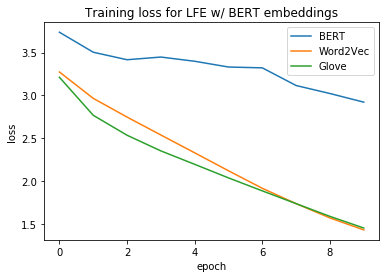

In [0]:
import matplotlib.pyplot as plt
train_loss_bert = [3.7378,3.5044,3.4167,3.4481,3.3988,3.3316,3.3219,3.1154,3.0220,2.9213]
train_loss_glove =  [3.2119,2.7680,2.5348,2.3519,2.1952,2.0366,1.8849,1.7356,1.5870,1.4513]
train_loss = [3.2735, 2.9659,2.7471,2.5377,2.3296,2.1196,1.9150,1.7356,1.569,1.4290]
plt.plot(train_loss_bert)
plt.plot(train_loss)
plt.plot(train_loss_glove)
plt.title("Training loss for LFE w/ BERT embeddings")
plt.xlabel("epoch")
plt.legend(['BERT','Word2Vec','Glove'])
plt.ylabel("loss")
plt.show()

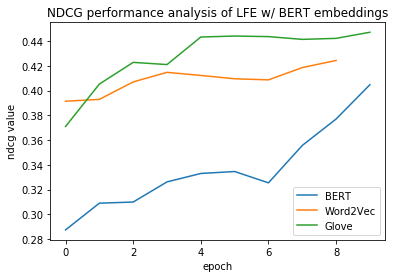

In [0]:
ndcg_bert = [0.2873266339302063,0.30894944071769714,0.30987516045570374,0.32616897344589233,0.33297746300697327,
         0.3345576910972595,0.3254027760028839,0.35563448905944824,0.3770192050933838, 0.4047586524486542]
ndcg = [0.39140427112579346,0.3929082155227661,0.40702003240585327,0.4147586524486542,
        0.41226211190223694,0.40957486629486084,0.4086861312389374,0.41862040758132935,
        0.4243660867214203]
ndcg_glove = [0.3709699213504791,0.40528053045272827,0.4228399693965912,0.421050101518631,0.4433402419090271,
              0.44412192702293396,0.443667471408844,0.4414273798465729,0.44224607944488525,0.44719642400741577]

plt.plot(ndcg_bert)
plt.plot(ndcg)
plt.plot(ndcg_glove)
plt.title("NDCG performance analysis of LFE w/ BERT embeddings")
plt.xlabel("epoch")
plt.ylabel("ndcg value")
plt.legend(['BERT','Word2Vec','Glove'])
plt.show()